In [1]:
from os import makedirs
from os.path import basename
from os.path import join
from urllib.request import urlopen
from urllib.parse import urljoin
from bs4 import BeautifulSoup
from os import walk
from os import listdir
from os.path import isfile, join
import glob

In [2]:
from spacepy import pycdf

import pandas as pd
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [ ]:
# load a file from a URL, returns content of downloaded file
def download_url(urlpath):
    # open a connection to the server
    with urlopen(urlpath) as connection:
        # read the contents of the url as bytes and return it
        return connection.read()

# decode downloaded html and extract all <a href=""> links
def get_urls_from_html(content):
    # decode the provided content as ascii text
    html = content.decode('utf-8')
    # parse the document as best we can
    soup = BeautifulSoup(html, 'html.parser')
    # find all all of the <a href=""> tags in the document
    atags = soup.find_all('a')
    # get all href values (links) or None if not present (unlikely)
    return [t.get('href', None) for t in atags]

# save provided content to the local path
def save_file(path, data):
    # open the local file for writing
    with open(path, 'wb') as file:
        # write all provided data to the file
        file.write(data)

# download one file to a local directory
def download_url_to_file(url, link, path):
    # skip bad urls or bad filenames
    if link is None or link == '../':
        return (link, None)
    # check for no file extension
    if not (link[-4] == '.' or link[-3] == '.' ):
        return (link, None)
    # convert relative link to absolute link
    absurl = urljoin(url, link)
    # download the content of the file
    data = download_url(absurl)
    # get the filename
    filename = basename(absurl)
    # construct the output path
    outpath = join(path, filename)
    # save to file
    save_file(outpath, data)
    # return results
    return (link, outpath)

# download all files on the provided webpage to the provided path
def download_all_files(url, path):
    # download the html webpage
    data = download_url(url)
    # create a local directory to save files
    makedirs(path, exist_ok=True)
    # parse html and retrieve all href urls listed
    links = get_urls_from_html(data)
    # report progress
    print(f'Found {len(links)} links in {url}')
    # download each file on the webpage
    for link in links:
        # download the url to a local file
        link, outpath = download_url_to_file(url, link, path)
        # check for a link that was skipped
        if outpath is None:
            print(f'>skipped {link}')
        else:
            print(f'Downloaded {link} to {outpath}')

In [ ]:
URL = 'https://cdaweb.gsfc.nasa.gov/pub/data/wind/mfi/mfi_h2/2022/'
PATH = 'mfi_h2_2022'

download_all_files(URL, PATH)

In [ ]:
URL = 'https://cdaweb.gsfc.nasa.gov/pub/data/wind/swe/swe_h1/2022/'
PATH = 'swe_h1_2022'

download_all_files(URL, PATH)

# MAG.CDF
First look 

In [3]:
mag = pycdf.CDF('/Users/admin/Desktop/dscovr_h0_mag_20220101_v01.cdf')

In [20]:
for row in mag:
    print()
    try:
        print(f"NAME: {mag[f'{row}'].meta['CATDESC']}")
        print(f"SHAPE: {mag[f'{row}'].shape}")
        print(f"SCALEMAX: {mag[f'{row}'].meta['SCALEMAX']}")
        print(f"SCALEMIN: {mag[f'{row}'].meta['SCALEMIN']}")
        print('-'*70)
    except: 
        'KeyError: no such attribute for variable'


NAME: Time, centered, number of milliseconds since the epoch (1 sec)
SHAPE: (86400,)
SCALEMAX: 2022-01-02 00:00:00
SCALEMIN: 2022-01-01 00:00:00
----------------------------------------------------------------------

NAME: Time, centered, in year, day, & milliseconds (1 sec)
SHAPE: (86400, 3)
SCALEMAX: [2022    2    0]
SCALEMIN: [2022    1    0]
----------------------------------------------------------------------

NAME: Number of points in average (1 sec)
SHAPE: (86400,)
SCALEMAX: 50
SCALEMIN: 0
----------------------------------------------------------------------

NAME: Magnetic field magnitude (1 sec)
SHAPE: (86400,)
SCALEMAX: 10.337989807128906
SCALEMIN: 6.200892925262451
----------------------------------------------------------------------

NAME: Standard deviation of B magnitude (1 sec)
SHAPE: (86400,)
SCALEMAX: 0.3389487862586975
SCALEMIN: 2.562095813285481e-10
----------------------------------------------------------------------

NAME: Magnetic field vector in GSE cartesia

In [5]:
print(mag)

B1F1: CDF_REAL4 [86400]
B1GSE: CDF_REAL4 [86400, 3]
B1RTN: CDF_REAL4 [86400, 3]
B1SDF1: CDF_REAL4 [86400]
B1SDGSE: CDF_REAL4 [86400, 3]
B1SDRTN: CDF_REAL4 [86400, 3]
Epoch1: CDF_EPOCH [86400]
FLAG1: CDF_INT2 [86400]
NUM1_PTS: CDF_INT4 [86400]
RANGE1: CDF_INT2 [86400]
SENS: CDF_REAL4 [3, 8] NRV
Time1_PB5: CDF_INT4 [86400, 3]
ZERO: CDF_REAL4 [3, 8] NRV
format_time: CDF_CHAR*2 [3] NRV
label_bgse: CDF_CHAR*8 [3] NRV
label_brtn: CDF_CHAR*8 [3] NRV
label_bsdgse: CDF_CHAR*14 [3] NRV
label_bsdrtn: CDF_CHAR*14 [3] NRV
label_time: CDF_CHAR*27 [3] NRV
unit_time: CDF_CHAR*4 [3] NRV


# BIG MAG

### convert to the dataframe of pandas ###
- Magnetic field magnitude (1 sec)
- Standard deviation of B magnitude (1 sec)
- Magnetic field vector in GSE cartesian coordinates (1 sec)
- Magnetic field vector in RTN cartesian coordinates (1 sec)
- Standard deviation of B vector in GSE coordinates (1 sec)
- Standard deviation of B vector in RTN coordinates (1 sec)
- Data quality flag (1 sec) 
- Magnetometer measurement range (1 sec)

Test

In [22]:
m = {'MFM': mag['B1F1'][:],
     'SDMFM': mag['B1SDF1'][:],
     f'{mag["label_bgse"][0]}': mag['B1GSE'][:,0], 
     f'{mag["label_bgse"][1]}': mag['B1GSE'][:,1], 
     f'{mag["label_bgse"][2]}': mag['B1GSE'][:,2],
     f'{mag["label_brtn"][0]}': mag['B1RTN'][:,0], 
     f'{mag["label_brtn"][1]}': mag['B1RTN'][:,1],
     f'{mag["label_brtn"][2]}': mag['B1RTN'][:,2],
     f'{mag["label_bsdgse"][0]}': mag['B1SDGSE'][:,0],
     f'{mag["label_bsdgse"][1]}': mag['B1SDGSE'][:,1],
     f'{mag["label_bsdgse"][2]}': mag['B1SDGSE'][:,2],
     f'{mag["label_bsdrtn"][0]}': mag['B1SDRTN'][:,0],
     f'{mag["label_bsdrtn"][1]}': mag['B1SDRTN'][:,1],
     f'{mag["label_bsdrtn"][2]}': mag['B1SDRTN'][:,2],
     f'{"DQF"}': mag['FLAG1'][:], 
     f'{"MMR"}': mag['RANGE1'][:],
     f'{"Epoch"}': mag['Epoch1'][:]}
df0 = pd.DataFrame(data=m)

In [23]:
df0

,MFM,SDMFM,Bx (GSE),By (GSE),Bz (GSE),Br (RTN),Bt (RTN),Bn (RTN),Bx_SIGMA (GSE),By_SIGMA (GSE),Bz_SIGMA (GSE),Br_SIGMA (RTN),Bt_SIGMA (RTN),Bn_SIGMA (RTN),DQF,MMR,Epoch
0,7.847697,0.065833,-6.046689,1.365650,-4.811000,6.048062,-1.919957,-4.616047,0.070164,0.068936,0.089979,0.070079,0.063679,0.093836,0,1,2022-01-01 00:00:00.500
1,7.856151,0.066168,-6.204004,1.468288,-4.589349,6.205013,-1.996704,-4.383909,0.062890,0.043437,0.101016,0.062865,0.044395,0.100615,0,1,2022-01-01 00:00:01.500
2,7.872819,0.061730,-6.249762,1.585235,-4.516116,6.250499,-2.104536,-4.297672,0.059856,0.100633,0.062112,0.059847,0.098524,0.065414,0,1,2022-01-01 00:00:02.500
3,7.901035,0.053906,-6.273651,2.018660,-4.355755,6.273473,-2.516695,-4.088529,0.058067,0.116566,0.080177,0.058089,0.110358,0.088513,0,1,2022-01-01 00:00:03.500
4,7.931902,0.066027,-6.299574,2.065079,-4.352795,6.299309,-2.562510,-4.080227,0.069538,0.115287,0.075381,0.069592,0.108161,0.085247,0,1,2022-01-01 00:00:04.500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86395,7.079707,0.059949,-1.774737,6.736413,-1.259014,1.763488,-6.839067,-0.480982,0.063675,0.057722,0.067549,0.063697,0.058679,0.066698,0,1,2022-01-01 23:59:55.500
86396,7.008308,0.040716,-1.833489,6.663606,-1.159757,1.822290,-6.755519,-0.390611,0.060875,0.039945,0.050000,0.060883,0.042070,0.048216,0,1,2022-01-01 23:59:56.500
86397,6.997936,0.046780,-1.836646,6.670567,-1.043551,1.825338,-6.749192,-0.274367,0.062750,0.045930,0.093689,0.062795,0.045243,0.093993,0,1,2022-01-01 23:59:57.500
86398,7.046858,0.055889,-1.868399,6.723170,-0.976579,1.856939,-6.793872,-0.201801,0.058122,0.045661,0.102415,0.058132,0.050044,0.100340,0,1,2022-01-01 23:59:58.500


All files 

In [24]:
f = []
for (dirpath, dirnames, filenames) in walk('/Users/admin/Desktop/Проекты/NASA/Datasets/mag_2022'):
    filenames.sort()
    for filename in filenames: 
        f.append(dirpath + '/' + filename)   

In [25]:
def read_all_mag_files(files=f[1:]):
    df_fin = []
    for file in files: 
        mag_f = pycdf.CDF(file)        
        m = {'Epoch': mag_f['Epoch1'][:], 
             'MFM': mag_f['B1F1'][:],
             'SDMFM': mag_f['B1SDF1'][:],
             f'{mag_f["label_bgse"][0]}': mag_f['B1GSE'][:,0], 
             f'{mag_f["label_bgse"][1]}': mag_f['B1GSE'][:,1], 
             f'{mag_f["label_bgse"][2]}': mag_f['B1GSE'][:,2],
             f'{mag_f["label_brtn"][0]}': mag_f['B1RTN'][:,0], 
             f'{mag_f["label_brtn"][1]}': mag_f['B1RTN'][:,1],
             f'{mag_f["label_brtn"][2]}': mag_f['B1RTN'][:,2],
             f'{mag_f["label_bsdgse"][0]}': mag_f['B1SDGSE'][:,0],
             f'{mag_f["label_bsdgse"][1]}': mag_f['B1SDGSE'][:,1],
             f'{mag_f["label_bsdgse"][2]}': mag_f['B1SDGSE'][:,2],
             f'{mag_f["label_bsdrtn"][0]}': mag_f['B1SDRTN'][:,0],
             f'{mag_f["label_bsdrtn"][1]}': mag_f['B1SDRTN'][:,1],
             f'{mag_f["label_bsdrtn"][2]}': mag_f['B1SDRTN'][:,2],
             f'{"DQF"}': mag_f['FLAG1'][:], 
             f'{"MMR"}': mag_f['RANGE1'][:]}
        df0 = pd.DataFrame(data=m)
        df_fin.append(df0)
        
    return df_fin

In [27]:
%%time
mag_all = read_all_mag_files(files=f[1:])

In [ ]:
mag_all = pd.concat(mag_all, axis=0)

In [ ]:
mag_all

# SWE.CDF

In [32]:
swe = pycdf.CDF('/Users/admin/Desktop/Проекты/NASA/Datasets/swe_h1_2022/wi_h1_swe_20220101_v01.cdf')

In [37]:
print(swe['Alpha_Na_nonlin'].meta)

CATDESC: Alpha number density Na (n/cc) from non-linear analysis [CDF_CHAR]
DELTA_MINUS_VAR: Alpha_sigmaNa_nonlin [CDF_CHAR]
DELTA_PLUS_VAR: Alpha_sigmaNa_nonlin [CDF_CHAR]
DEPEND_0: Epoch [CDF_CHAR]
DISPLAY_TYPE: time_series [CDF_CHAR]
FIELDNAM: Alpha number density Na (n/cc) from non-linear analysis [CDF_CHAR]
FILLVAL: -1e+31 [CDF_FLOAT]
FORMAT: E12.2 [CDF_CHAR]
LABLAXIS: He++ density nonlin [CDF_CHAR]
SCALETYP: linear [CDF_CHAR]
UNITS: cm^{-3} [CDF_CHAR]
VALIDMAX: 9999.99 [CDF_FLOAT]
VALIDMIN: 0.0 [CDF_FLOAT]
VAR_NOTES: Obtained from non-linear fitting to the ion current distribution function (CDF). [CDF_CHAR]
VAR_TYPE: data [CDF_CHAR]


In [39]:
for row in swe:
    print()
    try:
        print(f"NAME: {swe[f'{row}'].meta['CATDESC']}")
        print(f"SHAPE: {swe[f'{row}'].shape}")
        print(f"FILLVAL: {swe[f'{row}'].meta['FILLVAL']}")
        print(f"UNITS: {swe[f'{row}'].meta['UNITS']}")
        print('-'*70)
    except: 
        'KeyError: no such attribute for variable'


NAME: This flag denotes the fit quality and encodes any contingencies in the ion VDF analysis.
SHAPE: (579,)
FILLVAL: -128

NAME: CDF Epoch time at the beginning of each SWE spectrum (milliseconds)
SHAPE: (579,)
FILLVAL: 9999-12-31 23:59:59.999000
UNITS: ms
----------------------------------------------------------------------

NAME: year
SHAPE: (579,)
FILLVAL: -128
UNITS: years
----------------------------------------------------------------------

NAME: Fractional day of year of start of spectrum (Noon on January 1 = 1.5)
SHAPE: (579,)
FILLVAL: -9.999999848243207e+30
UNITS: day
----------------------------------------------------------------------

NAME: Proton bulk speed
SHAPE: (579,)
FILLVAL: -9.999999848243207e+30
UNITS: km/s
----------------------------------------------------------------------

NAME: 1-sigma uncertainty in the proton bulk speed
SHAPE: (579,)
FILLVAL: -9.999999848243207e+30
UNITS: km/s
----------------------------------------------------------------------

NAME:

Test

In [40]:
col_names = []
all_s = {}

for name in list(swe): 
    col_names.append(swe[name].meta['CATDESC'])
    all_s[f'{swe[name].meta["LABLAXIS"]}'] =  swe[name][:]
    
all_ = pd.DataFrame(data=all_s, index=swe['Epoch'][:])
all_.index.name = 'time'   

In [42]:
# col_names

In [43]:
f2 = []
for (dirpath, dirnames, filenames) in walk('/Users/admin/Desktop/Проекты/NASA/Datasets/swe_h1_2022'):
    filenames.sort()
    for filename in filenames: 
        f2.append(dirpath + '/' + filename)   

In [44]:
def read_all_swe_files(files=f2):
    df_fin = []
    for file_name in files: 
        swe_f = pycdf.CDF(file_name)        
        all_s = {}
        for name in list(swe_f): 
            all_s[f'{swe_f[name].meta["LABLAXIS"]}'] = swe_f[name][:]

        all_ = pd.DataFrame(data=all_s, index=swe_f['Epoch'][:])
        all_.index.name = 'time' 
        df_fin.append(all_)
        
    return df_fin

In [ ]:
%%time
swe_all = read_all_swe_files(files=f2)

In [ ]:
swe_all = pd.concat(swe_all, axis=0)

In [ ]:
swe_all

# MFI

In [45]:
mfi = pycdf.CDF('/Users/admin/Desktop/Проекты/NASA/Datasets/mfi_h2_2022/wi_h2_mfi_20220101_v04.cdf')

In [47]:
for row in mfi:
    print()
    try:
        print(f"NAME: {mfi[f'{row}'].meta['CATDESC']}")
        print(f"SHAPE: {mfi[f'{row}'].shape}")
        print(f"SCALEMAX: {mfi[f'{row}'].meta['SCALEMAX']}")
        print(f"SCALEMIN: {mfi[f'{row}'].meta['SCALEMIN']}")
        print('-'*70)
    except: 
        'KeyError: no such attribute for variable'


NAME: Time, Centered, Number of milliseconds since the epoch
SHAPE: (925803, 1)
SCALEMAX: 63808300800000.0
SCALEMIN: 63808214400000.0
----------------------------------------------------------------------

NAME: Time of observation in Year, Day, & milliseconds
SHAPE: (925803, 3)
SCALEMAX: [2022    2    0]
SCALEMIN: [2022    1    0]
----------------------------------------------------------------------

NAME: Magnetic field magnitude
SHAPE: (925803, 1)
SCALEMAX: 10.524374961853027
SCALEMIN: 4.717337131500244
----------------------------------------------------------------------

NAME: Magnetic field vector in GSM cartesian coordinates
SHAPE: (925803, 3)
SCALEMAX: [5.7666774 9.37033   9.529095 ]
SCALEMIN: [ -8.504769   -5.4079933 -10.388053 ]
----------------------------------------------------------------------

NAME: Magnetic field vector in GSE cartesian coordinates
SHAPE: (925803, 3)
SCALEMAX: [5.766862 9.097491 9.599997]
SCALEMIN: [ -8.504757  -5.855519 -10.29095 ]
----------------

### convert to the dataframe of pandas ###
- Time, Centered, Number of milliseconds since the epoch
- Magnetic field magnitude
- WIND/MFI operational mode
- Magnetometer Range 
- S/C operational mode 
- Magnetic field vector in GSE cartesian coordinates 
- Magnetic field vector in GSM cartesian coordinates (geocentric solar magnetospheric coordinates)

In [54]:
mf = {'Epoch': np.array(list(itertools.chain.from_iterable(mfi['Epoch'][:]))),
     'MFM': np.array(list(itertools.chain.from_iterable(mfi['BF1'][:]))),
     'WIND/MFI operational mode': np.array(list(itertools.chain.from_iterable(mfi['MAG_MODE'][:]))),
     'Magnetometer Range': np.array(list(itertools.chain.from_iterable(mfi['RANGE'][:]))),
     'S/C operational mode': np.array(list(itertools.chain.from_iterable(mfi['SPC_MODE'][:]))),
     f'{mfi["label_bgse"][0]}': mfi['BGSE'][:,0], 
     f'{mfi["label_bgse"][1]}': mfi['BGSE'][:,1], 
     f'{mfi["label_bgse"][2]}': mfi['BGSE'][:,2],
     f'{mfi["label_bgsm"][0]}': mfi['BGSM'][:,0], 
     f'{mfi["label_bgsm"][1]}': mfi['BGSM'][:,1], 
     f'{mfi["label_bgsm"][2]}': mfi['BGSM'][:,2]}

In [55]:
df00 = pd.DataFrame(data=mf)

In [57]:
df00

,Epoch,MFM,WIND/MFI operational mode,Magnetometer Range,S/C operational mode,Bx (GSE),By (GSE),Bz (GSE),Bx (GSM),By (GSM),Bz (GSM)
0,2022-01-01 00:00:00.078,8.328560,11,1,1,-5.987128,2.666523,-5.138955,-5.987275,3.903727,-4.275321
1,2022-01-01 00:00:00.170,8.314696,11,1,1,-5.991735,2.682342,-5.102776,-5.991881,3.909660,-4.236283
2,2022-01-01 00:00:00.262,8.315007,11,1,1,-6.024165,2.690811,-5.060466,-6.024309,3.906909,-4.193222
3,2022-01-01 00:00:00.354,8.316628,11,1,1,-6.029044,2.691353,-5.057029,-6.029188,3.906543,-4.189763
4,2022-01-01 00:00:00.446,8.352105,11,1,1,-6.059289,2.698425,-5.075548,-6.059433,3.918159,-4.205825
...,...,...,...,...,...,...,...,...,...,...,...
925798,2022-01-01 23:59:59.570,6.868853,11,1,1,-3.107488,6.118712,0.293287,-3.107482,5.821071,1.907835
925799,2022-01-01 23:59:59.662,6.887255,11,1,1,-3.126518,6.130242,0.281596,-3.126513,5.835291,1.899625
925800,2022-01-01 23:59:59.754,6.892120,11,1,1,-3.132273,6.134157,0.249607,-3.132268,5.847561,1.869823
925801,2022-01-01 23:59:59.846,6.884228,11,1,1,-3.105382,6.141171,0.187672,-3.105379,5.870773,1.811972


In [58]:
f3 = []
for (dirpath, dirnames, filenames) in walk('/Users/admin/Desktop/Проекты/NASA/Datasets/mfi_h2_2022'):
    filenames.sort()
    for filename in filenames: 
        f3.append(dirpath + '/' + filename)   

In [ ]:
def read_all_mfi_files(files=f3):
    df_fin = []
    for file in files: 
        mfi_f = pycdf.CDF(file)        
        mf = {'Epoch': np.array(list(itertools.chain.from_iterable(mfi_f['Epoch'][:]))),
             'MFM': np.array(list(itertools.chain.from_iterable(mfi_f['BF1'][:]))),
             'WIND/MFI operational mode': np.array(list(itertools.chain.from_iterable(mfi_f['MAG_MODE'][:]))),
             'Magnetometer Range': np.array(list(itertools.chain.from_iterable(mfi_f['RANGE'][:]))),
             'S/C operational mode': np.array(list(itertools.chain.from_iterable(mfi_f['SPC_MODE'][:]))),
             f'{mfi_f["label_bgse"][0]}': mfi_f['BGSE'][:,0], 
             f'{mfi_f["label_bgse"][1]}': mfi_f['BGSE'][:,1], 
             f'{mfi_f["label_bgse"][2]}': mfi_f['BGSE'][:,2],
             f'{mfi_f["label_bgsm"][0]}': mfi_f['BGSM'][:,0], 
             f'{mfi_f["label_bgsm"][1]}': mfi_f['BGSM'][:,1], 
             f'{mfi_f["label_bgsm"][2]}': mfi_f['BGSM'][:,2]}
        df00 = pd.DataFrame(data=mf)
        df_fin.append(df00)
        
    return df_fin

In [ ]:
%%time
mfi_all = read_all_mfi_files(files=f3)

In [ ]:
mfi_ = pd.concat(mfi_all, axis=0)

In [ ]:
mfi_.info()

# Saving datasets

In [ ]:
mag_all.to_csv(r'/Users/admin/Desktop/Проекты/NASA/Datasets/mag_all', index=False)

In [ ]:
swe_all.to_csv(r'/Users/admin/Desktop/Проекты/NASA/Datasets/swe_all', index=False)

In [ ]:
mfi_.to_csv(r'/Users/admin/Desktop/Проекты/NASA/Datasets/mfi_all', index=False)

Creating definitions dictionary for swe dataset.

In [ ]:
dic = {'Features': [],
      'Definition': []}
for i, j in zip(col_names, swe_all.columns):
    dic['Features'].append(j)
    dic['Definition'].append(i)    

In [ ]:
dic1 = pd.DataFrame(data=dic)

In [ ]:
dic1.to_csv(r'/Users/admin/Desktop/Проекты/NASA/Datasets/swe_dic', index=False)

## MAG and MFI
Feature Comparison 

In [59]:
mag_desc = ['Time, Centered, Number of milliseconds since the epoch',
            'Magnetic field magnitude (1 sec)', 'Standard deviation of B magnitude (1 sec)', 
            'Magnetic field vector in GSE cartesian coordinates (1 sec)', 
            'Magnetic field vector in RTN cartesian coordinates (1 sec)',
            'Standard deviation of B vector in GSE coordinates (1 sec)',
            'Standard deviation of B vector in RTN coordinates (1 sec)',
            'Data quality flag (1 sec)', 'Magnetometer measurement range (1 sec)']

In [60]:
mfi_desc = ['Time, Centered, Number of milliseconds since the epoch',
           'Magnetic field magnitude', 'WIND/MFI operational mode',
           'Magnetometer Range', 'S/C operational mode', 'Magnetic field vector in GSE cartesian coordinates',
           'Magnetic field vector in GSM cartesian coordinates (geocentric solar magnetospheric coordinates)']

In [63]:
lst = {'MAG_FE': mag_all.columns,
             'MAG_DESC': mag_desc,
             'MFI_FE': mfi_.columns,
             'MFI_DESC': mfi_desc}

In [64]:
pd.DataFrame(dict([(k, pd.Series(v)) for k,v in lst.items()]))

In [ ]:
pd.DataFrame(dict([(k, pd.Series(v)) for k,v in lst.items()])).iloc[:, 0].values

# Data preparation 

In [5]:
%time
mag_all = dd.read_csv(r'/Users/admin/Desktop/Проекты/NASA/Datasets/mag_all')

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.91 µs


In [6]:
%%time
swe_all = dd.read_csv(r'/Users/admin/Desktop/Проекты/NASA/Datasets/swe_all')

CPU times: user 10.8 ms, sys: 3.99 ms, total: 14.8 ms
Wall time: 13.5 ms


In [7]:
%%time
mfi_all = dd.read_csv(r'/Users/admin/Desktop/Проекты/NASA/Datasets/mfi_all')

CPU times: user 26 ms, sys: 4.33 ms, total: 30.4 ms
Wall time: 29.6 ms


In [8]:
swe_dic = dd.read_csv(r'/Users/admin/Desktop/Проекты/NASA/Datasets/swe_dic')

### Reset index 

In [9]:
mag_all = mag_all.reset_index(drop=True)

In [10]:
mfi_all = mfi_all.reset_index(drop=True)

In [11]:
swe_all = swe_all.reset_index(drop=True)

In [12]:
cols_to_leave = ['Epoch', 'proton bulk speed', 
                 'P+ W nonlin', 'Sigma P+ W nonlin', 
                 'P+ density', 'sigma P+ density',
                 'xgse', 'ygse','zgse']

In [13]:
swe_sel = swe_all.loc[:, cols_to_leave].copy()

In [14]:
swe_sel.head(1)

,Epoch,proton bulk speed,P+ W nonlin,Sigma P+ W nonlin,P+ density,sigma P+ density,xgse,ygse,zgse
0,2022-01-01 00:01:56.794,379.34863,31.200994,3.518043,4.496858,0.100365,241.87141,78.03,9.235564


### Removing all data after 23 of June 

In [15]:
%%time
mfi_all['Epoch'] = dd.to_datetime(mfi_all['Epoch'])
mag_all['Epoch'] = dd.to_datetime(mag_all['Epoch'])
swe_sel['Epoch'] = dd.to_datetime(swe_sel['Epoch'])

CPU times: user 18 ms, sys: 1.01 ms, total: 19 ms
Wall time: 18.2 ms


In [16]:
mag_all['Epoch'].tail(1)

364473   2022-06-23 23:59:59.500
Name: Epoch, dtype: datetime64[ns]

In [17]:
mfi_all = mfi_all.loc[mfi_all['Epoch'] < '2022-06-24']

In [18]:
swe_sel = swe_sel.loc[swe_sel['Epoch'] < '2022-06-24']

In [19]:
swe_sel.tail(1)

,Epoch,proton bulk speed,P+ W nonlin,Sigma P+ W nonlin,P+ density,sigma P+ density,xgse,ygse,zgse
133528,2022-06-23 23:59:15.631,440.64203,43.081623,1.0,3.968586,0.019843,245.31963,86.946884,8.363482


When converted to pandas df, everything is working fine.

In [20]:
mfi_all.tail(1)

,Epoch,MFM,WIND/MFI operational mode,Magnetometer Range,S/C operational mode,Bx (GSE),By (GSE),Bz (GSE),Bx (GSM),By (GSM),Bz (GSM)


In [191]:
len(swe_sel)

133529

In [190]:
len(mag_all)

14947200

In [65]:
len(mfi_all)

## Aggregation

In [21]:
swe_sel.Epoch = swe_sel.Epoch.dt.floor('H')

In [22]:
swe_agg = swe_sel.groupby(['Epoch']).agg(['mean', 'std']).compute()

/opt/miniconda3/envs/mainenv_2/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [23]:
swe_agg.columns = ["_".join(x) for x in swe_agg.columns]

In [24]:
%%time
mag_all.Epoch = mag_all.Epoch.dt.floor('H')
mag_agg = mag_all.groupby(['Epoch']).agg(['mean', 'std']).compute()
mag_agg.columns = ["_".join(x) for x in mag_agg.columns]

CPU times: user 50.6 s, sys: 9.55 s, total: 1min
Wall time: 19.9 s


In [25]:
%%time
mfi_all.Epoch = mfi_all.Epoch.dt.floor('H')
mfi_agg = mfi_all.groupby(['Epoch']).agg(['mean', 'std']).compute()
mfi_agg.columns = ["_".join(x) for x in mfi_agg.columns]

CPU times: user 8min 40s, sys: 1min 44s, total: 10min 25s
Wall time: 4min 1s


In [26]:
print(mag_agg.shape),
print(mfi_agg.shape),
print(swe_agg.shape)

(4152, 32)
(4173, 20)
(4170, 16)


## Saving agg dfs

In [27]:
mag_agg.to_csv(r'/Users/admin/Desktop/Проекты/NASA/Datasets/mag_agg')
mfi_agg.to_csv(r'/Users/admin/Desktop/Проекты/NASA/Datasets/mfi_agg')
swe_agg.to_csv(r'/Users/admin/Desktop/Проекты/NASA/Datasets/swe_agg')

## Trying DTW 

In [67]:
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis

In [262]:
mag_agg.head(2)

,MFM_mean,MFM_std,SDMFM_mean,SDMFM_std,Bx (GSE)_mean,Bx (GSE)_std,By (GSE)_mean,By (GSE)_std,Bz (GSE)_mean,Bz (GSE)_std,Br (RTN)_mean,Br (RTN)_std,Bt (RTN)_mean,Bt (RTN)_std,Bn (RTN)_mean,Bn (RTN)_std,Bx_SIGMA (GSE)_mean,Bx_SIGMA (GSE)_std,By_SIGMA (GSE)_mean,By_SIGMA (GSE)_std,Bz_SIGMA (GSE)_mean,Bz_SIGMA (GSE)_std,Br_SIGMA (RTN)_mean,Br_SIGMA (RTN)_std,Bt_SIGMA (RTN)_mean,Bt_SIGMA (RTN)_std,Bn_SIGMA (RTN)_mean,Bn_SIGMA (RTN)_std,DQF_mean,DQF_std,MMR_mean,MMR_std
Epoch,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:00:00,8.098292,0.244286,0.062161,0.012529,-5.869371,0.870457,3.595609,2.213857,-2.597576,2.415832,5.864921,0.873706,-3.880373,1.949260,-2.161230,2.632860,0.076211,0.031824,0.081689,0.055553,0.092696,0.064122,0.076226,0.031863,0.081341,0.052837,0.093457,0.065698,0.0,0.0,1.0,0.0
2022-01-01 01:00:00,8.840732,0.562994,0.062859,0.018803,-4.319543,1.212584,4.654611,2.102481,-1.675060,5.424345,4.312434,1.214860,-4.823577,1.642985,-1.124839,5.580274,0.091999,0.055783,0.090973,0.065414,0.109475,0.101335,0.092016,0.055805,0.093929,0.068365,0.107408,0.098844,0.0,0.0,1.0,0.0


In [272]:
mfi_agg.head(2)

,MFM_mean,MFM_std,WIND/MFI operational mode_mean,WIND/MFI operational mode_std,Magnetometer Range_mean,Magnetometer Range_std,S/C operational mode_mean,S/C operational mode_std,Bx (GSE)_mean,Bx (GSE)_std,By (GSE)_mean,By (GSE)_std,Bz (GSE)_mean,Bz (GSE)_std,Bx (GSM)_mean,Bx (GSM)_std,By (GSM)_mean,By (GSM)_std,Bz (GSM)_mean,Bz (GSM)_std
Epoch,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:00:00,8.353764,0.248635,11.0,0.0,1.0,0.0,1.0,0.0,-4.864467,1.445147,5.520732,1.401206,0.541552,3.370602,-4.864453,1.445224,5.216318,0.972510,1.913372,3.504177
2022-01-01 01:00:00,9.407645,0.488413,11.0,0.0,1.0,0.0,1.0,0.0,-2.198501,2.772861,2.194023,3.190525,-6.410193,4.487472,-2.198682,2.772797,3.579677,2.460912,-5.720471,4.962536


In [66]:
from tslearn.metrics import dtw

In [344]:
s1 = mag_agg['Bx (GSE)_mean'].values
s2 = mfi_agg['Bx (GSE)_mean'].values

In [345]:
dtw(s1, s2)

4.416883546387167e+31

# Merging

In [3]:
mag_agg = pd.read_csv(r'/Users/admin/Desktop/Проекты/NASA/Datasets/mag_agg')
mfi_agg = pd.read_csv(r'/Users/admin/Desktop/Проекты/NASA/Datasets/mfi_agg')
swe_agg = pd.read_csv(r'/Users/admin/Desktop/Проекты/NASA/Datasets/swe_agg')

In [4]:
merged = swe_agg.merge(mfi_agg, on='Epoch', how='left').merge(mag_agg, on='Epoch', how='left')

In [5]:
merged.shape

(4170, 69)

In [6]:
merged.columns 

Index(['Epoch', 'proton bulk speed_mean', 'proton bulk speed_std',
       'P+ W nonlin_mean', 'P+ W nonlin_std', 'Sigma P+ W nonlin_mean',
       'Sigma P+ W nonlin_std', 'P+ density_mean', 'P+ density_std',
       'sigma P+ density_mean', 'sigma P+ density_std', 'xgse_mean',
       'xgse_std', 'ygse_mean', 'ygse_std', 'zgse_mean', 'zgse_std',
       'MFM_mean_x', 'MFM_std_x', 'WIND/MFI operational mode_mean',
       'WIND/MFI operational mode_std', 'Magnetometer Range_mean',
       'Magnetometer Range_std', 'S/C operational mode_mean',
       'S/C operational mode_std', 'Bx (GSE)_mean_x', 'Bx (GSE)_std_x',
       'By (GSE)_mean_x', 'By (GSE)_std_x', 'Bz (GSE)_mean_x',
       'Bz (GSE)_std_x', 'Bx (GSM)_mean', 'Bx (GSM)_std', 'By (GSM)_mean',
       'By (GSM)_std', 'Bz (GSM)_mean', 'Bz (GSM)_std', 'MFM_mean_y',
       'MFM_std_y', 'SDMFM_mean', 'SDMFM_std', 'Bx (GSE)_mean_y',
       'Bx (GSE)_std_y', 'By (GSE)_mean_y', 'By (GSE)_std_y',
       'Bz (GSE)_mean_y', 'Bz (GSE)_std_y', 'Br (

In [7]:
target_cols = ['proton bulk speed_mean', 'P+ W nonlin_mean', 'P+ density_mean']

In [8]:
corr_df = pd.DataFrame(columns=[target_cols[0]],
            data=merged.loc[:, ~merged.columns.isin(target_cols)].corrwith(merged[target_cols[0]]
                                                                          ).sort_values()).reset_index()

In [9]:
corr2 = pd.DataFrame(merged.loc[:, ~merged.columns.isin(target_cols)].corrwith(merged[target_cols[1]]),
                    columns=[target_cols[1]]).reset_index()
corr3 = pd.DataFrame(merged.loc[:, ~merged.columns.isin(target_cols)].corrwith(merged[target_cols[2]]),
                    columns=[target_cols[2]]).reset_index()

In [10]:
cols_to_remove = ['Bn_SIGMA (RTN)_mean', 'Bt_SIGMA (RTN)_mean', 'Br_SIGMA (RTN)_mean', 'By_SIGMA (GSE)_mean',
                 'Bx_SIGMA (GSE)_mean', 'Bz (GSE)_mean_y', 'Bx (GSE)_mean_y', 'MFM_mean_y', 'Bt (RTN)_mean',
                 'By (GSE)_mean_y', 'Br (RTN)_mean', 'Bn (RTN)_mean', 'Bx (GSM)_mean', 'WIND/MFI operational mode_mean',
                 'WIND/MFI operational mode_std', 'S/C operational mode_mean', 'S/C operational mode_std',
                 'proton bulk speed_std', 'P+ W nonlin_std', 'Sigma P+ W nonlin_std', 'Sigma P+ W nonlin_mean',
                 'P+ density_std', 'sigma P+ density_mean', 'sigma P+ density_std', 'By (GSE)_std_y', 
                 'Bz (GSE)_std_y', 'Br (RTN)_std', 'Bt (RTN)_std', 'Bn (RTN)_std', 'Bn_SIGMA (RTN)_std',
                 'Bt_SIGMA (RTN)_std', 'Br_SIGMA (RTN)_std', 'Br (RTN)_std', 'Bt (RTN)_std',
                 'Bn (RTN)_std', 'By (GSE)_std_y', 'Bz (GSE)_std_y', 'Bx (GSE)_mean_x', 'Bx (GSM)_mean',
                 'By (GSM)_std', 'By (GSE)_std_x', 'By (GSE)_mean_x']

In [11]:
corr_df.merge(corr2, on='index').merge(corr3, on='index').set_index('index').sort_values(
    ['proton bulk speed_mean', 'P+ W nonlin_mean', 'P+ density_mean'])

,proton bulk speed_mean,P+ W nonlin_mean,P+ density_mean
index,,,
Bz (GSE)_mean_x,-0.040341,-0.011690,0.007876
Bn_SIGMA (RTN)_mean,-0.035498,0.005582,0.003286
Bt_SIGMA (RTN)_mean,-0.035498,0.005582,0.003286
Br_SIGMA (RTN)_mean,-0.035498,0.005582,0.003286
Bz_SIGMA (GSE)_mean,-0.035498,0.005582,0.003286
By_SIGMA (GSE)_mean,-0.035498,0.005582,0.003286
Bx_SIGMA (GSE)_mean,-0.035498,0.005582,0.003286
SDMFM_mean,-0.035498,0.005582,0.003286
Bz (GSM)_mean,-0.029202,-0.007237,0.006538


In [172]:
# cols_to_remove = list(np.unique(cols_to_remove))

In [12]:
merged2 = merged.drop(columns=cols_to_remove)

In [13]:
merged2.shape

(4170, 33)

In [14]:
merged2.loc[:, merged2.nunique() < 2].count()

Series([], dtype: int64)

In [15]:
cols_to_remove = ['Bn_SIGMA (RTN)_mean', 'Bt_SIGMA (RTN)_mean', 'Br_SIGMA (RTN)_mean', 'By_SIGMA (GSE)_mean',
                 'Bx_SIGMA (GSE)_mean', 'Bz (GSE)_mean_y', 'Bx (GSE)_mean_y', 'MFM_mean_y', 'Bt (RTN)_mean',
                 'By (GSE)_mean_y', 'Br (RTN)_mean', 'Bn (RTN)_mean', 'Bx (GSM)_mean', 'WIND/MFI operational mode_mean',
                 'WIND/MFI operational mode_std', 'S/C operational mode_mean', 'S/C operational mode_std',
                 'proton bulk speed_std', 'P+ W nonlin_std', 'Sigma P+ W nonlin_std', 'Sigma P+ W nonlin_mean',
                 'P+ density_std', 'sigma P+ density_mean', 'sigma P+ density_std', 'By (GSE)_std_y', 
                 'Bz (GSE)_std_y', 'Br (RTN)_std', 'Bt (RTN)_std', 'Bn (RTN)_std', 'Bn_SIGMA (RTN)_std',
                 'Bt_SIGMA (RTN)_std', 'Br_SIGMA (RTN)_std', 'Br (RTN)_std', 'Bt (RTN)_std',
                 'Bn (RTN)_std', 'By (GSE)_std_y', 'Bz (GSE)_std_y', 'Bx (GSE)_mean_x', 'Bx (GSM)_mean',
                 'By (GSM)_std', 'By (GSE)_std_x', 'By (GSE)_mean_x']

In [16]:
corr_df2 = pd.DataFrame(columns=[target_cols[0]],
            data=merged2.loc[:, ~merged2.columns.isin(target_cols)].corrwith(merged2[target_cols[0]]
                                                                          ).sort_values()).reset_index()

corr2_2 = pd.DataFrame(merged2.loc[:, ~merged2.columns.isin(target_cols)].corrwith(merged2[target_cols[1]]),
                    columns=[target_cols[1]]).reset_index()
corr3_2 = pd.DataFrame(merged2.loc[:, ~merged2.columns.isin(target_cols)].corrwith(merged2[target_cols[2]]),
                    columns=[target_cols[2]]).reset_index()


corr_df2.merge(corr2_2, on='index').merge(corr3_2, on='index').set_index('index').sort_values(
    ['proton bulk speed_mean', 'P+ W nonlin_mean', 'P+ density_mean'])

,proton bulk speed_mean,P+ W nonlin_mean,P+ density_mean
index,,,
Bz (GSE)_mean_x,-0.040341,-0.011690,0.007876
Bz_SIGMA (GSE)_mean,-0.035498,0.005582,0.003286
SDMFM_mean,-0.035498,0.005582,0.003286
Bz (GSM)_mean,-0.029202,-0.007237,0.006538
MMR_mean,-0.027924,0.007182,0.003241
MFM_std_x,-0.027028,0.034847,0.028854
ygse_std,-0.026593,0.011859,0.003290
Magnetometer Range_std,-0.023338,-0.033400,0.037755
MFM_mean_x,0.011446,0.071175,0.007967


In [17]:
merged2.Epoch = pd.to_datetime(merged2.Epoch)

In [18]:
merged2['Year'] = merged2.Epoch.dt.year
merged2['Month'] = merged2.Epoch.dt.month
merged2['Weekday'] = merged2.Epoch.dt.weekday
merged2['Week'] = merged2.Epoch.dt.isocalendar().week
merged2['Day'] = merged2.Epoch.dt.day
merged2['Hour'] = merged2.Epoch.dt.hour

In [19]:
merged2

,Epoch,proton bulk speed_mean,P+ W nonlin_mean,P+ density_mean,xgse_mean,xgse_std,ygse_mean,ygse_std,zgse_mean,zgse_std,MFM_mean_x,MFM_std_x,Magnetometer Range_mean,Magnetometer Range_std,Bx (GSE)_std_x,Bz (GSE)_mean_x,Bz (GSE)_std_x,Bx (GSM)_std,By (GSM)_mean,Bz (GSM)_mean,Bz (GSM)_std,MFM_std_y,SDMFM_mean,SDMFM_std,Bx (GSE)_std_y,Bx_SIGMA (GSE)_std,By_SIGMA (GSE)_std,Bz_SIGMA (GSE)_mean,Bz_SIGMA (GSE)_std,DQF_mean,DQF_std,MMR_mean,MMR_std,Year,Month,Weekday,Week,Day,Hour
0,2022-01-01 00:00:00,391.213910,33.095958,4.774251,241.888016,0.010170,78.001097,0.017702,9.239400,0.002349,8.353764,0.248635,1.0,0.0,1.445147,0.541552,3.370602,1.445224,5.216318,1.913372,3.504177,2.442856e-01,6.216101e-02,1.252932e-02,8.704565e-01,3.182375e-02,5.555277e-02,9.269561e-02,6.412228e-02,0.000000,0.000000,1.0000,0.000000,2022,1,5,52,1,0
1,2022-01-01 01:00:00,20363.179906,20032.764395,2.077514,241.954896,0.013378,77.884468,0.023395,9.254853,0.003093,9.407645,0.488413,1.0,0.0,2.772861,-6.410193,4.487472,2.772797,3.579677,-5.720471,4.962536,5.629945e-01,6.285925e-02,1.880289e-02,1.212584e+00,5.578341e-02,6.541389e-02,1.094750e-01,1.013345e-01,0.000000,0.000000,1.0000,0.000000,2022,1,5,52,1,1
2,2022-01-01 02:00:00,469.534265,25042.337060,2.657439,242.007585,0.010703,77.792186,0.018777,9.267037,0.002476,9.733155,0.315846,1.0,0.0,0.836559,-8.777968,0.924656,0.836565,4.690964,-8.032445,1.205765,2.732256e-01,6.031572e-02,9.986875e-03,8.258307e-01,3.177473e-02,6.671249e-02,6.726956e-02,2.935658e-02,0.000000,0.000000,1.0000,0.000000,2022,1,5,52,1,2
3,2022-01-01 03:00:00,5689.428201,10566.046787,1.786353,242.054959,0.014995,77.708916,0.026391,9.278000,0.003471,8.470742,0.351541,1.0,0.0,2.392117,-4.223753,3.603158,2.392064,4.901237,-3.526258,3.747419,3.021963e-01,5.919894e-02,1.058864e-02,1.516618e+00,3.066701e-02,5.561368e-02,6.757279e-02,3.299616e-02,0.000000,0.000000,1.0000,0.000000,2022,1,5,52,1,3
4,2022-01-01 04:00:00,448.340463,4395.609605,2.007983,242.093175,0.012781,77.641537,0.022566,9.286851,0.002961,8.839595,0.339693,1.0,0.0,0.663373,-0.260777,1.425054,0.663392,6.786501,0.442507,1.428644,4.347786e-01,5.794740e-02,1.109117e-02,6.287955e-01,2.598113e-02,3.766085e-02,8.747704e-02,6.253899e-02,0.000000,0.000000,1.0000,0.000000,2022,1,5,52,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4165,2022-06-23 19:00:00,466.700943,47.754189,5.214948,245.071061,0.015867,87.282603,0.021302,8.300632,0.004024,8.343007,0.287445,1.0,0.0,2.499440,2.796716,2.379470,2.499428,-1.606033,2.645517,2.714632,2.356695e+29,-5.555556e+27,2.356695e+29,2.356695e+29,2.356695e+29,2.356695e+29,-5.555556e+27,2.356695e+29,0.000556,0.023567,-17.2050,772.265426,2022,6,3,25,23,19
4166,2022-06-23 20:00:00,458.309254,6103.733467,4.409595,245.125564,0.016421,87.209334,0.022104,8.314456,0.004166,7.908048,0.182946,1.0,0.0,1.687265,2.927488,3.296157,1.687269,-3.796123,2.449345,3.321898,3.331944e+29,-1.111111e+28,3.331944e+29,3.331944e+29,3.331944e+29,3.331944e+29,-1.111111e+28,3.331944e+29,0.001111,0.033319,-35.4100,1091.844654,2022,6,3,25,23,20
4167,2022-06-23 21:00:00,460.088771,48.085102,4.287641,245.181544,0.016284,87.133875,0.021981,8.328658,0.004132,7.606243,0.254367,1.0,0.0,1.936973,-0.992587,2.741636,1.936973,-4.432269,-1.693865,2.598630,1.879890e-01,6.289273e-02,2.072927e-02,2.072784e+00,6.330367e-02,8.669438e-02,1.321217e-01,1.088451e-01,0.000000,0.000000,1.0000,0.000000,2022,6,3,25,23,21
4168,2022-06-23 22:00:00,449.969669,46.407472,4.144385,245.237609,0.016314,87.058098,0.022078,8.342893,0.004149,7.518193,0.131383,1.0,0.0,2.173067,-2.395117,3.779017,2.173060,-1.928150,-2.743552,3.553788,5.520023e+29,-3.055556e+28,5.520023e+29,5.520023e+29,5.520023e+29,5.520023e+29,-3.055556e+28,5.520023e+29,0.003056,0.055200,-99.1275,1808.856382,2022,6,3,25,23,22


In [20]:
merged2.drop('Epoch', axis=1, inplace=True)

# Baseline

In [3]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel, f_classif

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer 
from sklearn.metrics import mean_squared_error

In [154]:
merged2 = pd.read_csv(r'/Users/admin/Desktop/Проекты/NASA/Datasets/merged2')

In [155]:
merged = pd.read_csv(r'/Users/admin/Desktop/Проекты/NASA/Datasets/merged')

In [156]:
merged.set_index('Epoch', inplace=True)

In [157]:
target_cols = ['proton bulk speed_mean', 'P+ W nonlin_mean', 'P+ density_mean']

In [158]:
train_set=merged.iloc[0:3336,:]
test_set=merged.iloc[3336:,:]

In [159]:
print(train_set.shape),
print(test_set.shape)

(3336, 68)
(834, 68)


In [160]:
X_train = train_set.drop(columns=target_cols)
y_train = train_set.loc[:, target_cols]

In [161]:
X_test = test_set.drop(columns=target_cols)
y_test = test_set.loc[:, target_cols]

In [162]:
num_cols = []
for col in X_train: 
    if (X_train[col].dtype != 'object') & (X_train[col].name != target_cols):
        num_cols.append(col)
print(len(num_cols))
num_cols

65


['proton bulk speed_std',
 'P+ W nonlin_std',
 'Sigma P+ W nonlin_mean',
 'Sigma P+ W nonlin_std',
 'P+ density_std',
 'sigma P+ density_mean',
 'sigma P+ density_std',
 'xgse_mean',
 'xgse_std',
 'ygse_mean',
 'ygse_std',
 'zgse_mean',
 'zgse_std',
 'MFM_mean_x',
 'MFM_std_x',
 'WIND/MFI operational mode_mean',
 'WIND/MFI operational mode_std',
 'Magnetometer Range_mean',
 'Magnetometer Range_std',
 'S/C operational mode_mean',
 'S/C operational mode_std',
 'Bx (GSE)_mean_x',
 'Bx (GSE)_std_x',
 'By (GSE)_mean_x',
 'By (GSE)_std_x',
 'Bz (GSE)_mean_x',
 'Bz (GSE)_std_x',
 'Bx (GSM)_mean',
 'Bx (GSM)_std',
 'By (GSM)_mean',
 'By (GSM)_std',
 'Bz (GSM)_mean',
 'Bz (GSM)_std',
 'MFM_mean_y',
 'MFM_std_y',
 'SDMFM_mean',
 'SDMFM_std',
 'Bx (GSE)_mean_y',
 'Bx (GSE)_std_y',
 'By (GSE)_mean_y',
 'By (GSE)_std_y',
 'Bz (GSE)_mean_y',
 'Bz (GSE)_std_y',
 'Br (RTN)_mean',
 'Br (RTN)_std',
 'Bt (RTN)_mean',
 'Bt (RTN)_std',
 'Bn (RTN)_mean',
 'Bn (RTN)_std',
 'Bx_SIGMA (GSE)_mean',
 'Bx_SIGMA (

In [163]:
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median', missing_values=np.NaN)),
    ('std_scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
], remainder='passthrough')

mor = Pipeline([
    ('preprocessor', preprocessor),
    ('mor', MultiOutputRegressor(Ridge(random_state=123)))
])

In [164]:
mor = mor.fit(X_train, y_train)

In [165]:
predicted = mor.predict(X_test)

In [168]:
dic = {}
for t, p in zip(y_test, predicted): 
    dic = {y_test.columns[0]: np.mean(np.sqrt(np.power(y_test.iloc[:, 0].values - predicted[:, 0], 2).sum())),
           y_test.columns[1]: np.mean(np.sqrt(np.power(y_test.iloc[:, 1].values - predicted[:, 1], 2).sum())),
           y_test.columns[2]: np.mean(np.sqrt(np.power(y_test.iloc[:, 2].values - predicted[:, 2], 2).sum()))}

In [169]:
print(dic)

{'proton bulk speed_mean': 112013.718061703, 'P+ W nonlin_mean': 353.23406445848354, 'P+ density_mean': 124.6740816802662}


In [170]:
(y_test - predicted).describe()

,proton bulk speed_mean,P+ W nonlin_mean,P+ density_mean
count,834.000000,834.000000,834.000000
mean,475.974800,4.162309,0.033697
std,3851.712433,11.508408,4.319569
min,-5841.269481,-26.843100,-6.390196
25%,68.245353,-3.051790,-2.392912
50%,203.536813,2.579466,-1.054300
75%,515.834900,9.353356,0.861993
max,78476.303531,90.305338,35.368288


In [171]:
predicted2 = pd.DataFrame(predicted, columns=y_test.columns, index=y_test.index)
predicted2.columns = [x +'_pred' for x in predicted2.columns]

<AxesSubplot:xlabel='Epoch'>

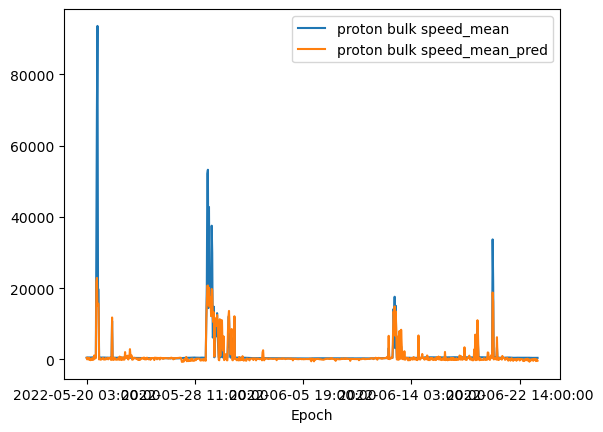

In [172]:
pd.concat([y_test.iloc[:, 0], predicted2.iloc[:, 0]], axis=1).plot()

<AxesSubplot:xlabel='Epoch'>

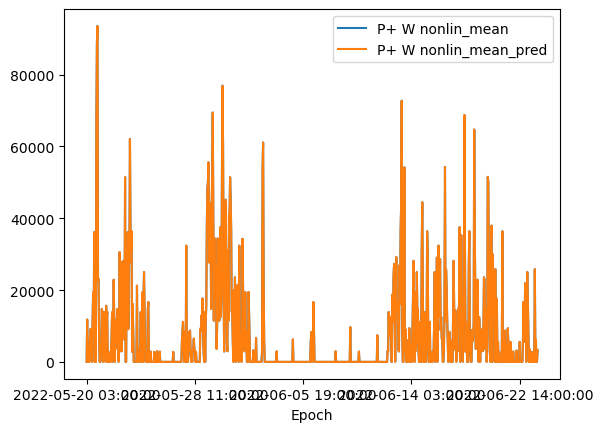

In [173]:
pd.concat([y_test.iloc[:, 1], predicted2.iloc[:, 1]], axis=1).plot()

<AxesSubplot:xlabel='Epoch'>

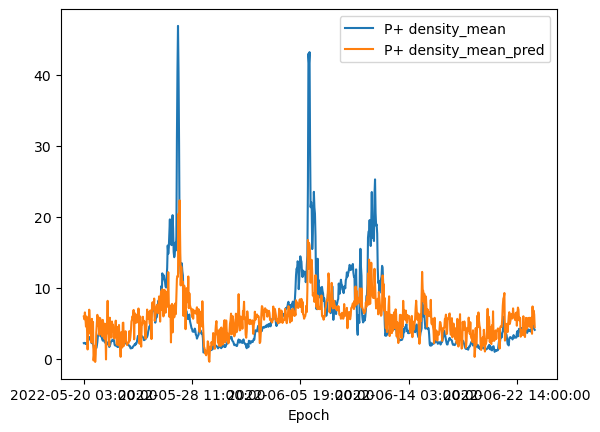

In [174]:
pd.concat([y_test.iloc[:, 2], predicted2.iloc[:, 2]], axis=1).plot()

In [175]:
import lightgbm as lgb
from tqdm import tqdm

In [176]:
merged2.Week = pd.to_numeric(merged2.Week)

In [177]:
y_pred = 0
N = 3
for i in tqdm(range(N)):
    model = MultiOutputRegressor(lgb.LGBMRegressor(random_state=i*101), n_jobs=-1)
    model.fit(X_train, y_train)
    y_pred += model.predict(X_test)
y_pred /= N

100%|█████████████████████████████████████████████| 3/3 [00:05<00:00,  1.72s/it]


In [178]:
y_pred

array([[5.29248980e+02, 6.97010090e+01, 1.88759610e+00],
       [5.06216427e+02, 1.19115368e+04, 2.26090200e+00],
       [5.25948800e+02, 6.67569758e+01, 1.93636720e+00],
       ...,
       [4.80702277e+02, 4.09496426e+01, 4.03974731e+00],
       [4.65743924e+02, 4.21426321e+01, 3.33013832e+00],
       [4.86355390e+02, 3.25890605e+03, 3.56880729e+00]])

In [182]:
dic2 = {}
for t, p in zip(y_test, y_pred): 
    dic2 = {y_test.columns[0]: np.mean(np.sqrt(np.power(y_test.iloc[:, 0].values - y_pred[:, 0], 2).sum())),
           y_test.columns[1]: np.mean(np.sqrt(np.power(y_test.iloc[:, 1].values - y_pred[:, 1], 2).sum())),
           y_test.columns[2]: np.mean(np.sqrt(np.power(y_test.iloc[:, 2].values - y_pred[:, 2], 2).sum()))}

print(dic2)

{'proton bulk speed_mean': 124359.77011598383, 'P+ W nonlin_mean': 20868.89011658152, 'P+ density_mean': 1153.4352266959593}


In [183]:
print(dic)

{'proton bulk speed_mean': 112013.718061703, 'P+ W nonlin_mean': 353.23406445848354, 'P+ density_mean': 124.6740816802662}


In [184]:
y_pred2 = pd.DataFrame(y_pred, columns=y_test.columns, index=y_test.index)
y_pred2.columns = [x +'_pred' for x in y_pred2.columns]

<AxesSubplot:xlabel='Epoch'>

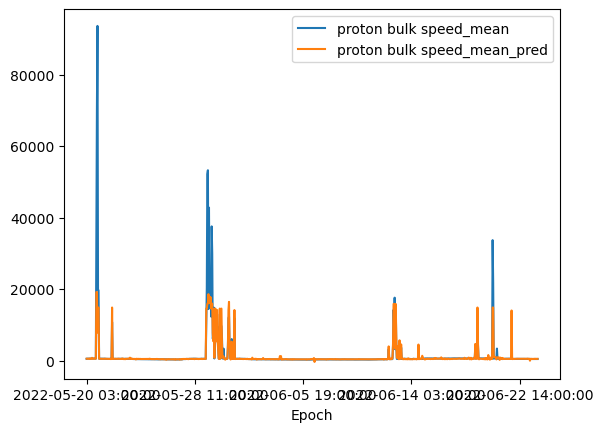

In [185]:
pd.concat([y_test.iloc[:, 0], y_pred2.iloc[:, 0]], axis=1).plot()

<AxesSubplot:xlabel='Epoch'>

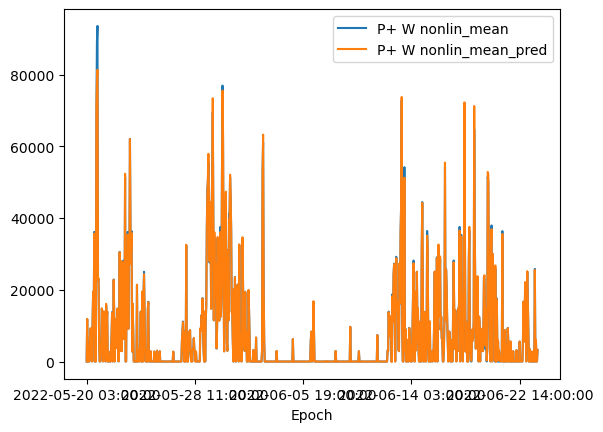

In [186]:
pd.concat([y_test.iloc[:, 1], y_pred2.iloc[:, 1]], axis=1).plot()

<AxesSubplot:xlabel='Epoch'>

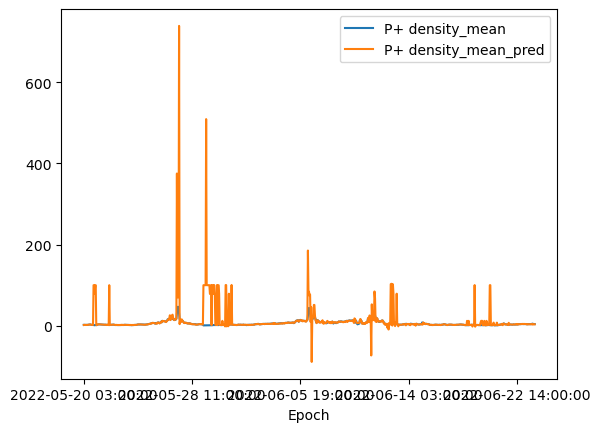

In [187]:
pd.concat([y_test.iloc[:, 2], y_pred2.iloc[:, 2]], axis=1).plot()

Shifting target value

In [188]:
def process_labels(target):
    y = target.copy()
    for tar in y:
        y[tar+'_1'] = y[tar].shift(-1)
    return y

In [189]:
labels = process_labels(merged[target_cols])
YCOLS = labels.columns
shifted_target = labels.iloc[:, -3:]

In [190]:
X_train_sh = train_set.drop(columns=target_cols)[:-1]
y_train_sh = shifted_target.iloc[0:3336,:][:-1]

X_test_sh = test_set.drop(columns=target_cols)[:-1]
y_test_sh = shifted_target.iloc[3336:,:][:-1]

In [191]:
y_pred_sh = 0
N = 3
for i in tqdm(range(N)):
    model = MultiOutputRegressor(lgb.LGBMRegressor(random_state=i*101), n_jobs=-1)
    model.fit(X_train_sh, y_train_sh)
    y_pred_sh += model.predict(X_test_sh)
y_pred_sh /= N

y_pred_sh

100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.07it/s]


array([[-3.84032153e+01,  4.83457969e+03,  1.78659667e+00],
       [ 4.33265248e+02,  1.10426028e+04,  2.04484525e+00],
       [ 1.09350997e+03,  6.68212626e+03,  1.79720736e+00],
       ...,
       [ 8.97658792e+01,  1.40327326e+04,  3.51136941e+00],
       [ 1.18619673e+03,  5.34173002e+03,  4.18875866e+00],
       [ 2.61393406e+02,  7.94095608e+03,  3.75757878e+00]])

In [192]:
dic3 = {}
for t, p in zip(y_test_sh, y_pred_sh): 
    dic3 = {y_test_sh.columns[0]: np.mean(np.sqrt(np.power(y_test_sh.iloc[:, 0].values - y_pred_sh[:, 0], 2).sum())),
           y_test_sh.columns[1]: np.mean(np.sqrt(np.power(y_test_sh.iloc[:, 1].values - y_pred_sh[:, 1], 2).sum())),
           y_test_sh.columns[2]: np.mean(np.sqrt(np.power(y_test_sh.iloc[:, 2].values - y_pred_sh[:, 2], 2).sum()))}

print(dic3)

{'proton bulk speed_mean_1': 159170.5308829708, 'P+ W nonlin_mean_1': 335229.93915549864, 'P+ density_mean_1': 1137.3352004486185}


In [193]:
print(dic2)

{'proton bulk speed_mean': 124359.77011598383, 'P+ W nonlin_mean': 20868.89011658152, 'P+ density_mean': 1153.4352266959593}


In [194]:
print(dic)

{'proton bulk speed_mean': 112013.718061703, 'P+ W nonlin_mean': 353.23406445848354, 'P+ density_mean': 124.6740816802662}


In [21]:
merged.to_csv(r'/Users/admin/Desktop/Проекты/NASA/Datasets/merged', index=False)

In [22]:
merged2.to_csv(r'/Users/admin/Desktop/Проекты/NASA/Datasets/merged2', index=False)

,proton bulk speed_mean_1,P+ W nonlin_mean_1,P+ density_mean_1
Epoch,,,
2022-06-23 19:00:00,458.309254,6103.733467,4.409595
2022-06-23 20:00:00,460.088771,48.085102,4.287641
2022-06-23 21:00:00,449.969669,46.407472,4.144385
2022-06-23 22:00:00,446.633225,3268.040881,4.056960
2022-06-23 23:00:00,NaN,NaN,NaN


In [8]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, LSTM
import pandas as pd

In [74]:
merged = pd.read_csv(r'/Users/admin/Desktop/Проекты/NASA/Datasets/merged')

In [84]:
merged2 = pd.read_csv(r'/Users/admin/Desktop/Проекты/NASA/Datasets/merged2')

In [85]:
merged2['Epoch'] = merged['Epoch']

In [86]:
merged2.set_index('Epoch', inplace=True)

In [88]:
merged2.drop(['Year', 'Month', 'Weekday', 'Week', 'Day', 'Hour'], axis=1, inplace=True)

In [89]:
from numpy.random import seed

seed(2020)

In [90]:
target_cols = ['proton bulk speed_mean', 'P+ W nonlin_mean', 'P+ density_mean']

In [91]:
from sklearn.preprocessing import StandardScaler

# subset of solar wind features to use for modeling
SOLAR_WIND_FEATURES = list(merged2.loc[:, ~merged2.columns.isin(target_cols)].columns)

In [92]:
XCOLS = SOLAR_WIND_FEATURES

In [93]:
def impute_features(feature_df):
    """Imputes data using the following methods:
    - `solar_wind`: interpolation
    """
    # interpolate between missing solar wind values
    feature_df = feature_df.interpolate()
    return feature_df

In [94]:
def preprocess_features(data, scaler=None, subset=None):
    """
    Preprocessing steps:
        - Subset the data
        - Aggregate hourly
        - Join solar wind and sunspot data
        - Scale using standard scaler
        - Impute missing values
    """
    # select features we want to use
    if subset:
        data = data[subset]

    # subtract mean and divide by standard deviation
    if scaler is None:
        scaler = StandardScaler()
        scaler.fit(data)
        
    normalized = pd.DataFrame(
            scaler.transform(data),
            index=data.index,
            columns=data.columns)

    # impute missing values
    imputed = impute_features(normalized)

    # we want to return the scaler object as well to use later during prediction
    return imputed, scaler

In [95]:
features, scaler = preprocess_features(merged2, subset=SOLAR_WIND_FEATURES)
print(features.shape)
features.head()

(4170, 29)


,xgse_mean,xgse_std,ygse_mean,ygse_std,zgse_mean,zgse_std,MFM_mean_x,MFM_std_x,Magnetometer Range_mean,Magnetometer Range_std,...,SDMFM_std,Bx (GSE)_std_y,Bx_SIGMA (GSE)_std,By_SIGMA (GSE)_std,Bz_SIGMA (GSE)_mean,Bz_SIGMA (GSE)_std,DQF_mean,DQF_std,MMR_mean,MMR_std
Epoch,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:00:00,0.808548,0.180570,1.074945,-0.723299,0.901872,-0.578155,0.739378,-0.332161,0.028908,-0.362442,...,-0.297268,-0.297404,-0.297268,-0.297268,0.184738,-0.297268,-0.185239,-0.297404,0.185223,-0.297407
2022-01-01 01:00:00,0.811681,0.684111,1.073349,-0.324969,0.903697,-0.131212,1.087989,0.265955,0.028908,-0.362442,...,-0.297268,-0.297404,-0.297268,-0.297268,0.184738,-0.297268,-0.185239,-0.297404,0.185223,-0.297407
2022-01-01 02:00:00,0.814150,0.264214,1.072086,-0.648127,0.905137,-0.501947,1.195664,-0.164507,0.028908,-0.362442,...,-0.297268,-0.297404,-0.297268,-0.297268,0.184738,-0.297268,-0.185239,-0.297404,0.185223,-0.297407
2022-01-01 03:00:00,0.816369,0.937844,1.070947,-0.115419,0.906432,0.096050,0.778074,-0.075468,0.028908,-0.362442,...,-0.297268,-0.297404,-0.297268,-0.297268,0.184738,-0.297268,-0.185239,-0.297404,0.185223,-0.297407
2022-01-01 04:00:00,0.818160,0.590289,1.070025,-0.383003,0.907478,-0.210765,0.900086,-0.105021,0.028908,-0.362442,...,-0.297268,-0.297404,-0.297268,-0.297268,0.184738,-0.297268,-0.185239,-0.297404,0.185223,-0.297407


In [96]:
assert (features.isna().sum() == 0).all()

In [97]:
merged2[target_cols[0]].shift(-1)

Epoch
2022-01-01 00:00:00    20363.179906
2022-01-01 01:00:00      469.534265
2022-01-01 02:00:00     5689.428201
2022-01-01 03:00:00      448.340463
2022-01-01 04:00:00      457.166342
                           ...     
2022-06-23 19:00:00      458.309254
2022-06-23 20:00:00      460.088771
2022-06-23 21:00:00      449.969669
2022-06-23 22:00:00      446.633225
2022-06-23 23:00:00             NaN
Name: proton bulk speed_mean, Length: 4170, dtype: float64

In [98]:
YCOLS = ["t1_0", "t1_1"
         "t2_0", "t2_1"
         "t3_0", "t3_1"]


def process_labels(target):
    y = target.copy()
    for tar in y:
        y[tar+'_1'] = y[tar].shift(-1)
    return y

In [107]:
labels = process_labels(merged2[target_cols])
YCOLS = labels.columns
labels.head()

,proton bulk speed_mean,P+ W nonlin_mean,P+ density_mean,proton bulk speed_mean_1,P+ W nonlin_mean_1,P+ density_mean_1
Epoch,,,,,,
2022-01-01 00:00:00,391.213910,33.095958,4.774251,20363.179906,20032.764395,2.077514
2022-01-01 01:00:00,20363.179906,20032.764395,2.077514,469.534265,25042.337060,2.657439
2022-01-01 02:00:00,469.534265,25042.337060,2.657439,5689.428201,10566.046787,1.786353
2022-01-01 03:00:00,5689.428201,10566.046787,1.786353,448.340463,4395.609605,2.007983
2022-01-01 04:00:00,448.340463,4395.609605,2.007983,457.166342,46.303379,2.084846


In [100]:
data = labels.join(features)
data.head()

,proton bulk speed_mean,P+ W nonlin_mean,P+ density_mean,proton bulk speed_mean_1,P+ W nonlin_mean_1,P+ density_mean_1,xgse_mean,xgse_std,ygse_mean,ygse_std,...,SDMFM_std,Bx (GSE)_std_y,Bx_SIGMA (GSE)_std,By_SIGMA (GSE)_std,Bz_SIGMA (GSE)_mean,Bz_SIGMA (GSE)_std,DQF_mean,DQF_std,MMR_mean,MMR_std
Epoch,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:00:00,391.213910,33.095958,4.774251,20363.179906,20032.764395,2.077514,0.808548,0.180570,1.074945,-0.723299,...,-0.297268,-0.297404,-0.297268,-0.297268,0.184738,-0.297268,-0.185239,-0.297404,0.185223,-0.297407
2022-01-01 01:00:00,20363.179906,20032.764395,2.077514,469.534265,25042.337060,2.657439,0.811681,0.684111,1.073349,-0.324969,...,-0.297268,-0.297404,-0.297268,-0.297268,0.184738,-0.297268,-0.185239,-0.297404,0.185223,-0.297407
2022-01-01 02:00:00,469.534265,25042.337060,2.657439,5689.428201,10566.046787,1.786353,0.814150,0.264214,1.072086,-0.648127,...,-0.297268,-0.297404,-0.297268,-0.297268,0.184738,-0.297268,-0.185239,-0.297404,0.185223,-0.297407
2022-01-01 03:00:00,5689.428201,10566.046787,1.786353,448.340463,4395.609605,2.007983,0.816369,0.937844,1.070947,-0.115419,...,-0.297268,-0.297404,-0.297268,-0.297268,0.184738,-0.297268,-0.185239,-0.297404,0.185223,-0.297407
2022-01-01 04:00:00,448.340463,4395.609605,2.007983,457.166342,46.303379,2.084846,0.818160,0.590289,1.070025,-0.383003,...,-0.297268,-0.297404,-0.297268,-0.297268,0.184738,-0.297268,-0.185239,-0.297404,0.185223,-0.297407


In [101]:
print(round(data.shape[0] * 0.7))
print(round(data.shape[0] * 0.2))
print(round(data.shape[0] * 0.1))

2919
834
417


In [102]:
train = data.iloc[:2919, :]
val = data.iloc[2919:3753, :]
test = data.iloc[3753:, :]

In [103]:
train.shape, val.shape, test.shape

((2919, 35), (834, 35), (417, 35))

In [104]:
data_config = {
    "timesteps": 32,
    "batch_size": 32,
}

In [120]:
import tensorflow as tf
from keras import preprocessing

def timeseries_dataset_from_df(df, batch_size):
    dataset = None
    timesteps = data_config["timesteps"]

    # iterate through periods
    for _, period_df in df.groupby("Epoch"):
        # realign features and labels so that first sequence of 32 is aligned with the 33rd target
        inputs = period_df[XCOLS][:-timesteps]
        outputs = period_df[YCOLS][timesteps:]

        period_ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            inputs,
            outputs,
            timesteps,
            batch_size=batch_size,
        )

        if dataset is None:
            dataset = period_ds
        else:
            dataset = dataset.concatenate(period_ds)

    return dataset

In [121]:
train_ds = timeseries_dataset_from_df(train, data_config["batch_size"])
val_ds = timeseries_dataset_from_df(val, data_config["batch_size"])

print(f"Number of train batches: {len(train_ds)}")
print(f"Number of val batches: {len(val_ds)}")

In [122]:
# define our model
model_config = {"n_epochs": 20, "n_neurons": 512, "dropout": 0.4, "stateful": False}

model = Sequential()
model.add(
    LSTM(
        model_config["n_neurons"],
        # usually set to (`batch_size`, `sequence_length`, `n_features`)
        # setting the batch size to None allows for variable length batches
        batch_input_shape=(None, data_config["timesteps"], len(XCOLS)),
        stateful=model_config["stateful"],
        dropout=model_config["dropout"],
    )
)

The tensorflow environment broke down and we had no time to restore it.